In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy
%matplotlib inline

In [14]:
ws = '/DelawareStream/Model/Test'
if not os.path.exists(ws): #make sure workspace directory exists
    os.makedirs(ws)
name = 'test'
exe_name = os.path.abspath('../bin/swtv4')

In [15]:
swt = flopy.seawat.Seawat(modelname=name, 
                          model_ws=ws, exe_name=exe_name)
print(swt.namefile)

test.nam


#### Building and post-processing a MODFLOW-2005 model

The model domain will be discretized into 3 layers, 21 rows, and 20 columns. A constant value of 500. will delr and delc. The top of the model should be set to 400 and the bottom of the three layers should be set to 220, 200, and 0. The model has one steady-state stress period.

In [16]:
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.
top = 400.
botm = [220, 200, 0]

In [17]:
dis = flopy.modflow.ModflowDis(swt, nlay=nlay, nrow=nrow, 
                               ncol=ncol, top=top, botm=botm, 
                               delr=delr, delc=delc)

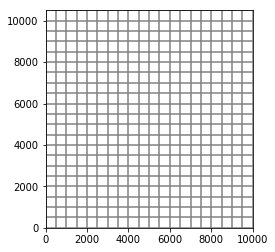

In [18]:
mm = flopy.plot.PlotMapView(model = swt)
mm.plot_grid()
#dis.plot()

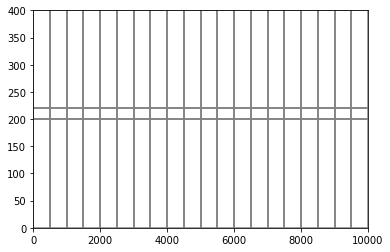

In [19]:
xs = flopy.plot.PlotCrossSection(model=swt, line={'row': 10})
xs.plot_grid()

#### Create the basic (BAS) package

Set the initial head at 320. Default values can be used for the rest of the basic package input.

In [20]:
bas = flopy.modflow.ModflowBas(swt, strt=320) 

#### Create the layer property flow (LPF) package  

The hydraulic properties for the model are defined in the image above. The first layer should be convertible (unconfined) and the remaining two layers will be non-convertible so laytyp should be [1, 0, 0].

In [21]:
kh = [50, 0.01, 200]
kv = [10, 0.01, 20]
laytyp = [1, 0, 0]

#### Create the recharge package

The recharge rate is defined in the image above.

In [22]:
rch = flopy.modflow.ModflowRch(swt, rech=0.005)

#### Create the well package

The well is located in layer 3, row 11, column 10. The pumping rate is defined in the image above.

In [23]:
wel_spd = {0: [[2, 10, 9, -150000]]}
wel = flopy.modflow.ModflowWel(swt, stress_period_data=wel_spd)

#### Create the river package

The river is located in layer 1 and column 20 in every row in the model. The river stage stage and bottom are at 320 and 318, respectively; the river conductance is 1e5.

In [24]:
riv_spd = {0: [[0, i, 19, 320, 1e5, 318] for i in range(nrow)]}
riv_spd
riv = flopy.modflow.ModflowRiv(swt, stress_period_data=riv_spd)

#### Add the PCG solver package

Set rclose to 0.1 and use default values for the PCG package variables.

In [25]:
pcg = flopy.modflow.ModflowPcg(swt, rclose=0.1)

#### Build output control

Define the output control for the model and set `stress_period_data` to `{(0, 0): ['save head', 'save budget']}` to save the head and flow for the model. Because we haven't set `ipakcb` to save flows for the packages we can use the `.reset_budgetunit()` method on the oc object to set the `ipakcb` for all packages that can save flows; set `budgetunit` to 131.

In [26]:
oc = flopy.modflow.ModflowOc(swt, stress_period_data={(0, 0): ['save head', 'save budget']})
oc.reset_budgetunit(budgetunit=131)

#### Create the basic MT3DMS and Seawatmodel structure


In [27]:
qinflow = 5.702  #m3/day
dmcoef = 0.57024 #m2/day  Could also try 1.62925 as another case of the Henry problem
hk = 864.  #m/day

# save cell fluxes to unit 53
ipakcb = 53

# Create WEL and SSM data
itype = flopy.mt3d.Mt3dSsm.itype_dict()
wel_data = {}
ssm_data = {}
wel_sp1 = wel_spd
ssm_sp1 = []
for k in range(nlay):
    #wel_sp1.append([k, 0, 0, qinflow / 3]) 
    ssm_sp1.append([k, 0, 0, 0., itype['WEL']])
    ssm_sp1.append([k, 0, ncol - 1, 35., itype['BAS6']])
wel_data[0] = wel_sp1
ssm_data[0] = ssm_sp1
wel = flopy.modflow.ModflowWel(swt, stress_period_data=wel_data, ipakcb=ipakcb)




#mt = flopy.mt3d.Mt3dms(modelname, 'nam_mt3dms', mf, model_ws=workspace)
btn = flopy.mt3d.Mt3dBtn(swt, nprs=-5, prsity=0.35, sconc=35., ifmtcn=0,
                         chkmas=False, nprobs=10, nprmas=10, dt0=0.001)
adv = flopy.mt3d.Mt3dAdv(swt, mixelm=0)
dsp = flopy.mt3d.Mt3dDsp(swt, al=0., trpt=1., trpv=1., dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(swt, iter1=500, mxiter=1, isolve=1, cclose=1e-7)
ssm = flopy.mt3d.Mt3dSsm(swt, stress_period_data=ssm_data)

#mswt = flopy.seawat.Seawat(modelname, 'nam_swt', mf, mt, model_ws=workspace, exe_name='swtv4')
vdf = flopy.seawat.SeawatVdf(swt, iwtable=0, densemin=0, densemax=0,
                             denseref=1000., denseslp=0.7143, firstdt=1e-3)

Exception: MfList error: unsupported data type: <class 'dict'> at kper 0

#### Write the model files and run the model

In [28]:
swt.write_input()
swt.run_model()

Exception: The program C:\Users\Admin\Desktop\Chelsea\Projects\DelawareStream\Script\bin\swtv4 does not exist or is not executable.

#### Try to delete the output files, to prevent accidental use of older files

In [53]:
try:
    os.remove(os.path.join(ws, 'MT3D001.UCN'))
    os.remove(os.path.join(ws, name + '.hds'))
    os.remove(os.path.join(ws, name + '.cbc'))
except:
    pass

In [ ]:
v = swt.run_model(silent=True, report=True)
for idx in range(-3, 0):
    print(v[1][idx])

#### Post-process the results

Load the heads and face flows from the hds and cbc files. The head file can be loaded with the `flopy.utils.HeadFile()` method. The cell-by-cell file can be loaded with the `flopy.utils.CellBudgetFile()` method. The entries in the cell-by-cell file can be determined with the `.list_unique_records()` method on the cell budget file object.

In [58]:
# Post-process the results
import flopy.utils.binaryfile as bf

# Load data
ucnobj = bf.UcnFile(os.path.join(ws, 'MT3D001.UCN'), model=swt)
times = ucnobj.get_times()
concentration = ucnobj.get_data(totim=times[-1])
cbbobj = bf.CellBudgetFile(os.path.join(ws, 'test.cbc'))
times = cbbobj.get_times()
qx = cbbobj.get_data(text='flow right face', totim=times[-1])[0]
qz = cbbobj.get_data(text='flow lower face', totim=times[-1])[0]

# Average flows to cell centers
qx_avg = np.empty(qx.shape, dtype=qx.dtype)
qx_avg[:, :, 1:] = 0.5 * (qx[:, :, 0:ncol-1] + qx[:, :, 1:ncol])
qx_avg[:, :, 0] = 0.5 * qx[:, :, 0]
qz_avg = np.empty(qz.shape, dtype=qz.dtype)
qz_avg[1:, :, :] = 0.5 * (qz[0:nlay-1, :, :] + qz[1:nlay, :, :])
qz_avg[0, :, :] = 0.5 * qz[0, :, :]

Exception: The specified text string is not in the budget file.

In [ ]:
fpth = os.path.join(ws, name+'.hds')
hobj = flopy.utils.HeadFile(fpth)
hds = hobj.get_data()
fpth = os.path.join(ws, name+'.cbc')
cobj = flopy.utils.CellBudgetFile(fpth)
cobj.list_unique_records()

Retrieve the `'FLOW RIGHT FACE'` and `'FLOW FRONT FACE'` data types from the cell-by-cell file.

In [49]:
frf = cobj.get_data(text='FLOW RIGHT FACE')[0]
fff = cobj.get_data(text='FLOW FRONT FACE')[0]

Exception: The specified text string is not in the budget file.

#### Plot the results

Plot the results using flopy.plot.PlotMapView(). The head results can be plotted using the .plot_array() method. The discharge results can be plotted using the plot_discharge() method. Boundary conditions can be plotted using the .plot_bc() method.

NameError: name 'mv' is not defined

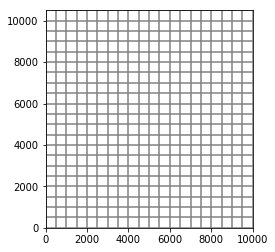

In [50]:
mm = flopy.plot.PlotMapView(model=swt, layer=0)
mm.plot_grid()
mv.plot_array(hds, cmap='jet') #plot simulated heads
mm.plot_array(hds)
mm.plot_discharge(frf=frf, fff=fff)
mm.plot_bc('RIV')
mm.plot_bc('WEL')